In [1]:
import pandas as pd
import numpy as np
import os
!pip install pyextremes
from pyextremes import EVA
import glob
import time
from concurrent.futures import ProcessPoolExecutor
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
def calculate_gev_events(df):
    # Define the return periods and years
    return_periods = {
        '10_year': 10,
        '100_year': 100
    }
    years = {
        '1979': 1979,
        '2020': 2020
    }

    # Placeholder function to calculate GEV event value
    def calculate_gev_event(shape, scale, location, return_period):
        return location + scale / shape * (1 - (-np.log(1 - 1 / return_period)) ** shape)

    # Initialize a list to hold the new rows for the output DataFrame
    new_data = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        county = row['county']
        
        # Dictionary to store the calculated values for this row
        new_row = {'county': county}
        
        # Loop through each variable (assuming columns follow the naming convention)
        for variable in row.filter(like='type_').index.str.replace('type_', ''):
            
            # Extract the GEV parameters for this variable
            shape = row[f'shape_{variable}']
            a = row[f'a_{variable}']
            b = row[f'b_{variable}']
            c = row[f'c_{variable}']
            d = row[f'd_{variable}']
            
            for period_name, period in return_periods.items():
                for year_name, year in years.items():
                    
                    # Calculate scale and location for the specified year
                    scale = a + b * year
                    location = c + d * year
                    
                    # Calculate the event value for the specified return period and year
                    event_value = calculate_gev_event(shape, scale, location, period)
                    
                    # Add the event value to the new_row dictionary with the correct column name
                    new_row[f'{period_name}_{year_name}_{variable}'] = event_value
                
                # Calculate the ratio between 1979 and 2020 for each period
                new_row[f'{period_name}_ratio_{variable}'] = new_row[f'{period_name}_1979_{variable}'] / new_row[f'{period_name}_2020_{variable}']
        
        # Append the dictionary to the list of new data
        new_data.append(new_row)

    # Create and return the new DataFrame
    return pd.DataFrame(new_data)

In [3]:
# Load MSWEP Params
MSWEP_Params = pd.read_csv('Nonstationary_Params/MSWEP_Params.csv')

# Load ERA5 Params
ERA5_Params = pd.read_csv('Nonstationary_Params/ERA5_Params.csv')

In [4]:
MSWEP_events = calculate_gev_events(MSWEP_Params)
ERA5_events = calculate_gev_events(ERA5_Params)

In [5]:
MSWEP_events = MSWEP_events[MSWEP_events['county'] != 'MASTER']
ERA5_events = ERA5_events[ERA5_events['county'] != 'MASTER']

MSWEP_events['county'] = MSWEP_events['county'].astype(int).astype(str)
MSWEP_events['county'] = MSWEP_events['county'].apply(lambda x: str(x).zfill(5))

ERA5_events['county'] = ERA5_events['county'].astype(int).astype(str)
ERA5_events['county'] = ERA5_events['county'].apply(lambda x: str(x).zfill(5))

In [6]:
# Load the county shapefile
county_shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load MSWEP and ERA5 event data and merge them with counties shapefile
gdf_counties_mSWEP = gdf_counties.merge(
    MSWEP_events[['county', '100_year_ratio_MSWEP_precipitation_30d_max_3d_sum', '100_year_ratio_MSWEP_precipitation_30d_max']],
    left_on='GEOID', right_on='county', how='left'
)
gdf_counties_ERA5 = gdf_counties.merge(
    ERA5_events[['county', '100_year_ratio_ERA5_precipitation_30d_max_3d_sum', '100_year_ratio_ERA5_precipitation_30d_max']],
    left_on='GEOID', right_on='county', how='left'
)

# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Define the custom color palette with reversed discrete color blocks (20 colors)
colors = [
    '#4e000a', '#67000d', '#99000d', '#cb181d', '#ef3b2c', '#fb6a4a', '#fc9272', '#fcbba1', '#fee0d2', '#fff5f0',
    '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#308bd9', '#2171b5', '#19568a', '#08306b', '#062553'  # Dark blue for highest values
]
cmap = mcolors.LinearSegmentedColormap.from_list('reversed_bwr', colors, N=20)

# Define boundaries to map each color block for values from 0 to 2
bounds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# Plot each dataset on a separate subplot
# MSWEP 30d Max 3d Sum
gdf_counties_mSWEP.plot(column='100_year_ratio_MSWEP_precipitation_30d_max_3d_sum', cmap=cmap, linewidth=0.8, ax=axs[0, 0], edgecolor='0.6', norm=norm)
axs[0, 0].set_title('100-Year Ratio for MSWEP Precipitation (30d Max, 3d Sum) by County')
axs[0, 0].set_xlim(extent[0], extent[1])
axs[0, 0].set_ylim(extent[2], extent[3])
axs[0, 0].axis('off')

# ERA5 30d Max 3d Sum
gdf_counties_ERA5.plot(column='100_year_ratio_ERA5_precipitation_30d_max_3d_sum', cmap=cmap, linewidth=0.8, ax=axs[0, 1], edgecolor='0.6', norm=norm)
axs[0, 1].set_title('100-Year Ratio for ERA5 Precipitation (30d Max, 3d Sum) by County')
axs[0, 1].set_xlim(extent[0], extent[1])
axs[0, 1].set_ylim(extent[2], extent[3])
axs[0, 1].axis('off')

# MSWEP 30d Max
gdf_counties_mSWEP.plot(column='100_year_ratio_MSWEP_precipitation_30d_max', cmap=cmap, linewidth=0.8, ax=axs[1, 0], edgecolor='0.6', norm=norm)
axs[1, 0].set_title('100-Year Ratio for MSWEP Precipitation (30d Max) by County')
axs[1, 0].set_xlim(extent[0], extent[1])
axs[1, 0].set_ylim(extent[2], extent[3])
axs[1, 0].axis('off')

# ERA5 30d Max
gdf_counties_ERA5.plot(column='100_year_ratio_ERA5_precipitation_30d_max', cmap=cmap, linewidth=0.8, ax=axs[1, 1], edgecolor='0.6', norm=norm)
axs[1, 1].set_title('100-Year Ratio for ERA5 Precipitation (30d Max) by County')
axs[1, 1].set_xlim(extent[0], extent[1])
axs[1, 1].set_ylim(extent[2], extent[3])
axs[1, 1].axis('off')

# Load and plot state boundaries on all subplots
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)
for ax in axs.flat:
    gdf_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Add a colorbar below all subplots with more spacing
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Use fig.subplots_adjust to increase space for colorbar
fig.subplots_adjust(bottom=0.15)  # Adjusts the bottom margin to create space

# Add colorbar below with larger pad
cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.3)  # Larger pad to ensure no overlap
cbar.set_label('100-Year Ratio (Precipitation)')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.2, 1, 1])  # Leaves space at bottom for the colorbar
plt.show()

/tmp/ipykernel_5595/2641243961.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Leaves space at bottom for the colorbar


/tmp/ipykernel_5595/21554638.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Leaves space at bottom for the colorbar


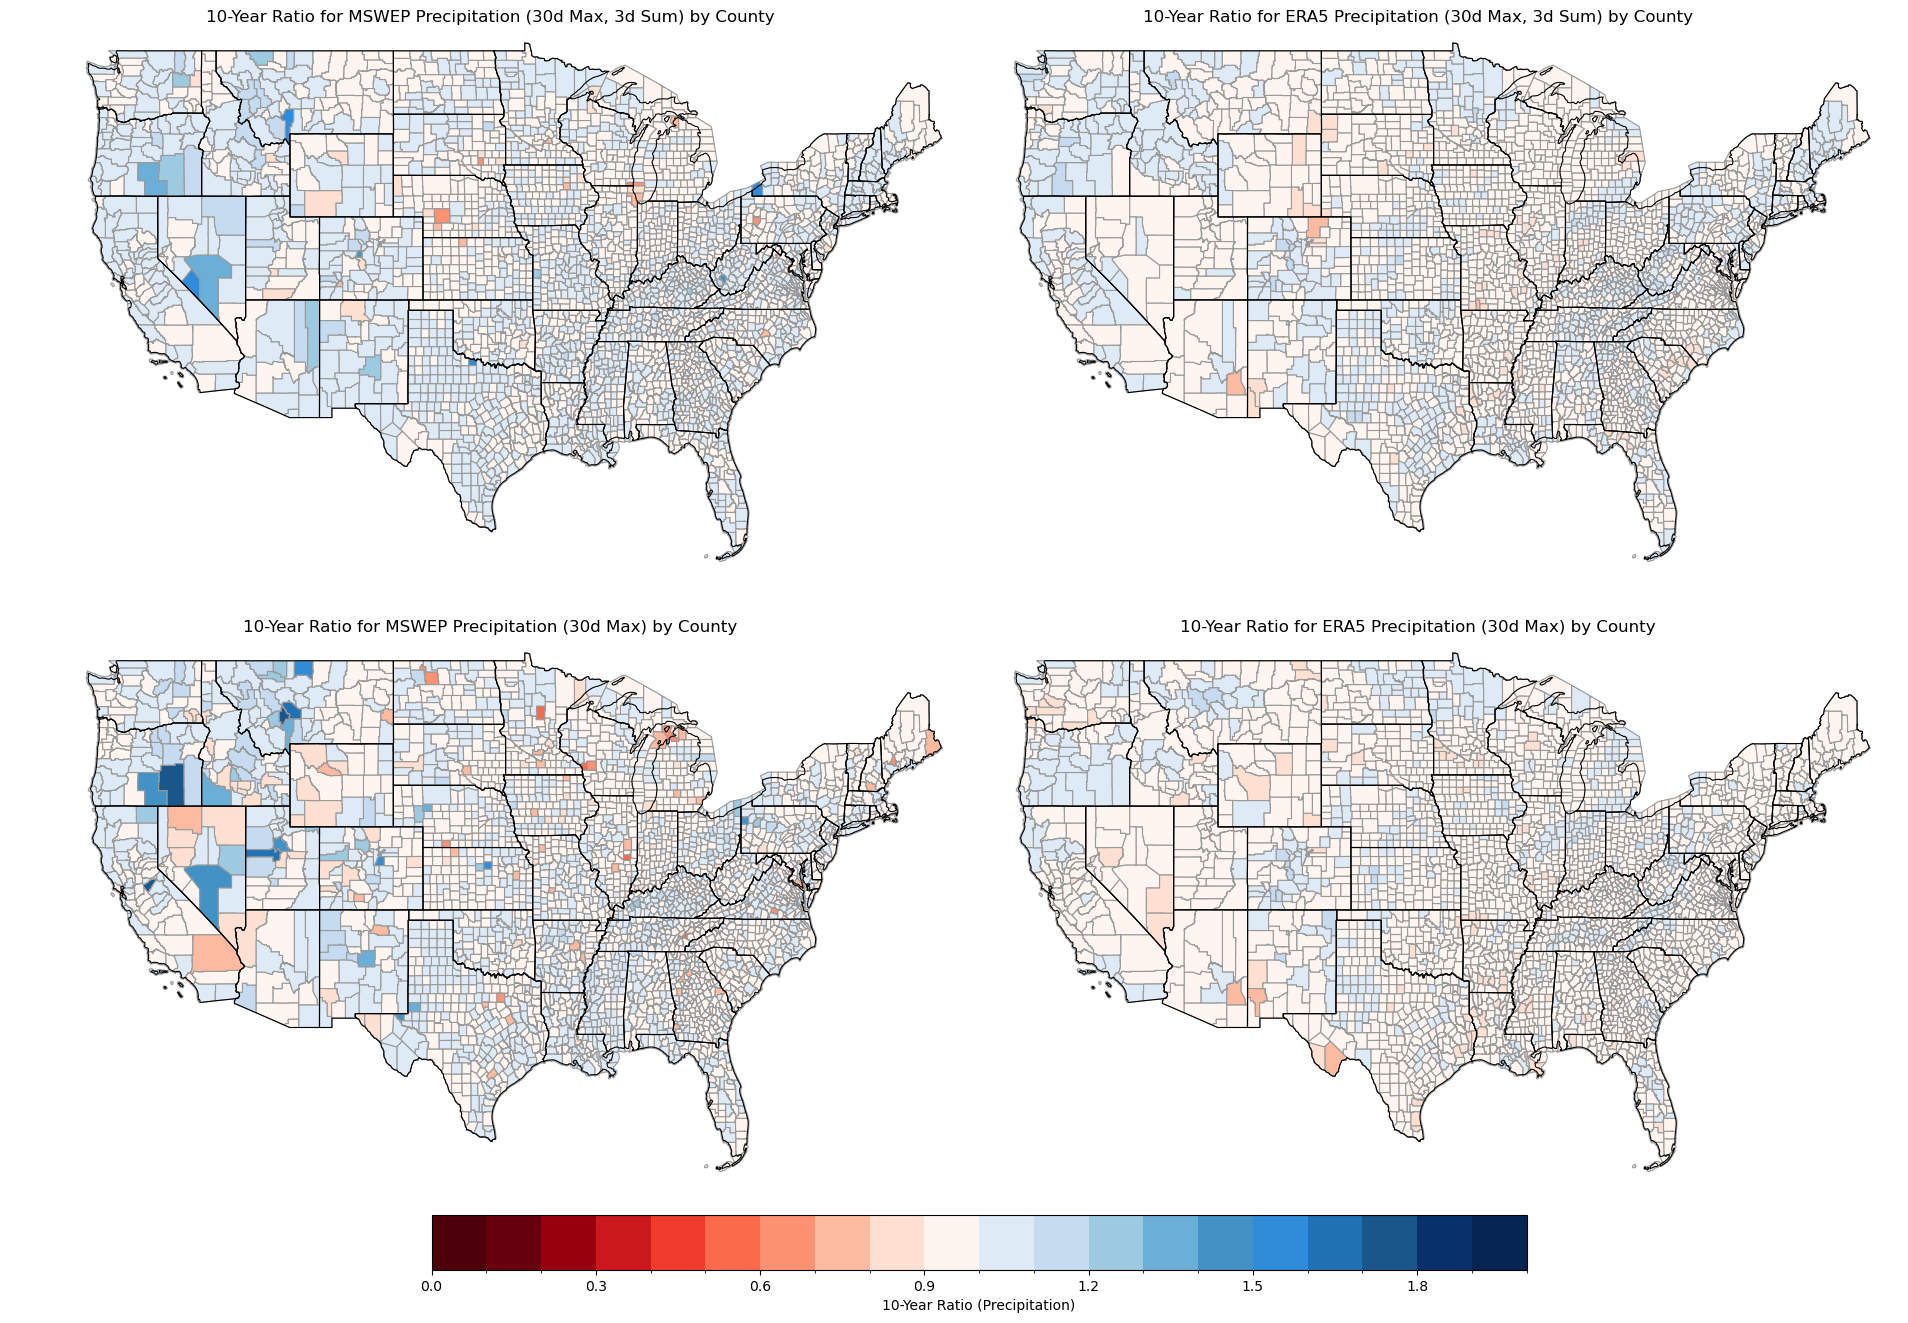

In [7]:
# Load the county shapefile
county_shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load MSWEP and ERA5 event data and merge them with counties shapefile
gdf_counties_mSWEP = gdf_counties.merge(
    MSWEP_events[['county', '10_year_ratio_MSWEP_precipitation_30d_max_3d_sum', '10_year_ratio_MSWEP_precipitation_30d_max']],
    left_on='GEOID', right_on='county', how='left'
)
gdf_counties_ERA5 = gdf_counties.merge(
    ERA5_events[['county', '10_year_ratio_ERA5_precipitation_30d_max_3d_sum', '10_year_ratio_ERA5_precipitation_30d_max']],
    left_on='GEOID', right_on='county', how='left'
)

# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Define the custom color palette with reversed discrete color blocks (20 colors)
colors = [
    '#4e000a', '#67000d', '#99000d', '#cb181d', '#ef3b2c', '#fb6a4a', '#fc9272', '#fcbba1', '#fee0d2', '#fff5f0',
    '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#308bd9', '#2171b5', '#19568a', '#08306b', '#062553'  # Dark blue for highest values
]
cmap = mcolors.LinearSegmentedColormap.from_list('reversed_bwr', colors, N=20)

# Define boundaries to map each color block for values from 0 to 2
bounds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# Plot each dataset on a separate subplot
# MSWEP 30d Max 3d Sum
gdf_counties_mSWEP.plot(column='10_year_ratio_MSWEP_precipitation_30d_max_3d_sum', cmap=cmap, linewidth=0.8, ax=axs[0, 0], edgecolor='0.6', norm=norm)
axs[0, 0].set_title('10-Year Ratio for MSWEP Precipitation (30d Max, 3d Sum) by County')
axs[0, 0].set_xlim(extent[0], extent[1])
axs[0, 0].set_ylim(extent[2], extent[3])
axs[0, 0].axis('off')

# ERA5 30d Max 3d Sum
gdf_counties_ERA5.plot(column='10_year_ratio_ERA5_precipitation_30d_max_3d_sum', cmap=cmap, linewidth=0.8, ax=axs[0, 1], edgecolor='0.6', norm=norm)
axs[0, 1].set_title('10-Year Ratio for ERA5 Precipitation (30d Max, 3d Sum) by County')
axs[0, 1].set_xlim(extent[0], extent[1])
axs[0, 1].set_ylim(extent[2], extent[3])
axs[0, 1].axis('off')

# MSWEP 30d Max
gdf_counties_mSWEP.plot(column='10_year_ratio_MSWEP_precipitation_30d_max', cmap=cmap, linewidth=0.8, ax=axs[1, 0], edgecolor='0.6', norm=norm)
axs[1, 0].set_title('10-Year Ratio for MSWEP Precipitation (30d Max) by County')
axs[1, 0].set_xlim(extent[0], extent[1])
axs[1, 0].set_ylim(extent[2], extent[3])
axs[1, 0].axis('off')

# ERA5 30d Max
gdf_counties_ERA5.plot(column='10_year_ratio_ERA5_precipitation_30d_max', cmap=cmap, linewidth=0.8, ax=axs[1, 1], edgecolor='0.6', norm=norm)
axs[1, 1].set_title('10-Year Ratio for ERA5 Precipitation (30d Max) by County')
axs[1, 1].set_xlim(extent[0], extent[1])
axs[1, 1].set_ylim(extent[2], extent[3])
axs[1, 1].axis('off')

# Load and plot state boundaries on all subplots
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)
for ax in axs.flat:
    gdf_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Add a colorbar below all subplots with more spacing
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Use fig.subplots_adjust to increase space for colorbar
fig.subplots_adjust(bottom=0.15)  # Adjusts the bottom margin to create space

# Add colorbar below with larger pad
cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.3)  # Larger pad to ensure no overlap
cbar.set_label('10-Year Ratio (Precipitation)')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.2, 1, 1])  # Leaves space at bottom for the colorbar
plt.show()

In [8]:
# Load the county shapefile
county_shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load MSWEP and ERA5 event data and merge them with counties shapefile
gdf_counties_mSWEP = gdf_counties.merge(
    MSWEP_events[['county', '10_year_ratio_MSWEP_precipitation_30d_max_3d_sum', '100_year_ratio_MSWEP_precipitation_30d_max_3d_sum']],
    left_on='GEOID', right_on='county', how='left'
)
gdf_counties_ERA5 = gdf_counties.merge(
    ERA5_events[['county', '10_year_ratio_ERA5_precipitation_30d_max_3d_sum', '100_year_ratio_ERA5_precipitation_30d_max_3d_sum']],
    left_on='GEOID', right_on='county', how='left'
)

# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

# Define the custom color palette with reversed discrete color blocks (20 colors)
colors = [
    '#67000d', '#99000d', '#cb181d', '#ef3b2c', '#fb6a4a', '#fc9272', '#fcbba1', '#fee0d2',
    '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#308bd9', '#2171b5', '#19568a', '#08306b'  # Dark blue for highest values
]
cmap = mcolors.LinearSegmentedColormap.from_list('reversed_bwr', colors, N=20)

# Define boundaries to map each color block for values from 0 to 2
bounds = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1, 1.125, 1.25, 1.375, 1.5, 1.625, 1.75, 1.875, 2]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Set up a 2x2 grid of subplots with limited width and scaled height
fig, axs = plt.subplots(2, 2, figsize=(7.09, 7.09 * 15 / 20))

# Set the overall figure title closer to the first plot
fig.suptitle('Nonstationary Trends in Return Periods', fontsize=11, y=0.95)

# Define panel labels and offset for non-overlapping positioning
panel_labels = ['a)', 'b)', 'c)', 'd)']
label_offset = (0.02, 1.05)  # Adjusted to avoid overlap

# Plot each dataset on a separate subplot with very thin light grey borders
# MSWEP 30d Max 3d Sum
gdf_counties_mSWEP.plot(column='10_year_ratio_MSWEP_precipitation_30d_max_3d_sum', cmap=cmap, ax=axs[0, 0], edgecolor='grey', linewidth=0.1, norm=norm)
axs[0, 0].set_title('MSWEP')
axs[0, 0].set_ylabel("10 Year")
axs[0, 0].set_xlim(extent[0], extent[1])
axs[0, 0].set_ylim(extent[2], extent[3])
axs[0, 0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axs[0, 0].text(label_offset[0], label_offset[1], panel_labels[0], transform=axs[0, 0].transAxes, ha='left', va='top', fontsize=12, fontweight='bold')
for spine in axs[0, 0].spines.values():
    spine.set_visible(False)

# ERA5 30d Max 3d Sum
gdf_counties_ERA5.plot(column='10_year_ratio_ERA5_precipitation_30d_max_3d_sum', cmap=cmap, ax=axs[0, 1], edgecolor='grey', linewidth=0.1, norm=norm)
axs[0, 1].set_title('ERA5')
axs[0, 1].set_xlim(extent[0], extent[1])
axs[0, 1].set_ylim(extent[2], extent[3])
axs[0, 1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axs[0, 1].text(label_offset[0], label_offset[1], panel_labels[1], transform=axs[0, 1].transAxes, ha='left', va='top', fontsize=12, fontweight='bold')
for spine in axs[0, 1].spines.values():
    spine.set_visible(False)

# MSWEP 30d Max
gdf_counties_mSWEP.plot(column='100_year_ratio_MSWEP_precipitation_30d_max_3d_sum', cmap=cmap, ax=axs[1, 0], edgecolor='grey', linewidth=0.1, norm=norm)
axs[1, 0].set_xlim(extent[0], extent[1])
axs[1, 0].set_ylabel("100 Year")
axs[1, 0].set_ylim(extent[2], extent[3])
axs[1, 0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axs[1, 0].text(label_offset[0], label_offset[1], panel_labels[2], transform=axs[1, 0].transAxes, ha='left', va='top', fontsize=12, fontweight='bold')
for spine in axs[1, 0].spines.values():
    spine.set_visible(False)

# ERA5 30d Max
gdf_counties_ERA5.plot(column='100_year_ratio_ERA5_precipitation_30d_max_3d_sum', cmap=cmap, ax=axs[1, 1], edgecolor='grey', linewidth=0.1, norm=norm)
axs[1, 1].set_xlim(extent[0], extent[1])
axs[1, 1].set_ylim(extent[2], extent[3])
axs[1, 1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axs[1, 1].text(label_offset[0], label_offset[1], panel_labels[3], transform=axs[1, 1].transAxes, ha='left', va='top', fontsize=12, fontweight='bold')
for spine in axs[1, 1].spines.values():
    spine.set_visible(False)

# Load and plot state boundaries on all subplots
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)
for ax in axs.flat:
    gdf_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

# Add a colorbar below all subplots with more spacing
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Use fig.subplots_adjust to increase space for colorbar
fig.subplots_adjust(bottom=0.15)  # Adjusts the bottom margin to create space

# Add colorbar below with larger pad
cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.3)  # Larger pad to ensure no overlap
cbar.set_label('Precipitation Event Ratio (2020 to 1979)')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.2, 1, 0.95])  # Leaves space at bottom for the colorbar
plt.savefig('Plots/Fig_6_Nonstationary.png', dpi=500)

plt.show()

/tmp/ipykernel_5595/3523873488.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 0.95])  # Leaves space at bottom for the colorbar
